# Extract features

## Choice of model for transfer learning
The [Inception v3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) and [MobileNet v2](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2) are both up to the task of extracting high-level features from the data. The TF Hub implementations of MobileNet and of Inception have been trained on the ILSVRC-2012-CLS "ImageNet" data set, and have the [same signature for feature vectors](https://www.tensorflow.org/hub/common_signatures/images#feature-vector).

The MobileNet v2 is optimized for mobile applications. Since I'm not building a mobile application, I chose the Inception v3 model. This model expects slightly larger input images and yields 2048 features for each image.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import tensorflow_hub as hub

print('Tensorflow version: {}, TF hub version: {}'.format(tf.__version__, hub.__version__))

Tensorflow version: 1.12.0, TF hub version: 0.4.0


## Create a network
Create a network for extracting high-level features from image data, by loading the chosen pre-trained model from TF Hub. The network has a placeholder for the image input and an output node. Initialize the network.

In [2]:
img_graph = tf.Graph()

with img_graph.as_default():
    # pretrained network Inception v3
    module_url = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
    feature_extractor = hub.Module(module_url)
    
    # expected size of input images
    height, width = hub.get_expected_image_size(feature_extractor)
    
    # placeholder for input
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
    
    # node that represents extracted high-level features
    imgs_features = feature_extractor(input_imgs)
    
    # initializers required by TensorFlow Hub
    init_op = tf.group(
        [tf.global_variables_initializer(), tf.tables_initializer()]
    )

img_graph.finalize() # make graph read-only

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Extract features from point clouds
Extract and save the features from point cloud data for each of the train, validate and test datasets saved in notebook 2. Each dataset consists of images representing 3 views of a pot: eleveation (front), plan (top) and section views.

In [3]:
import numpy as np
import os

PROD_DIR = 'production' # interim production files
TF_SIZE = 299

def convert_images(data):
    """
    Standardize and convert the image data.
    Image data created in notebook 2 is a flattened image with 3 channles og integer values in range 0 to 255. 
    These values have to be standardized to range 0 to 1 before beeing fed to the network.
    @param np_image_array data 
    @return image generator
    """
    X = []
    for idx in range(len(data)):
        flat_img = data[idx, :] # get some image
        flat_img = flat_img/255  # standardize values to 0-1
        img = flat_img.reshape(299,299, 3) # sqrt 784
        X.append(img)
    return (img for img in X)

def load_point_cloud(dataset_name):
    """
    Load point cloud data prepared in notebook 2.
    @param dataset_name string 'train', 'test' or 'validate'
    @returns numpy.ndarray metadata, numpy.ndarray 299*299 3-channel flattened Images elevation, plan, section
    """
    with np.load(os.path.join('data', dataset_name, 'point_clouds.npz'), allow_pickle=True) as data:
        data_dict = dict(data.items())

    metadata = data_dict['metadata']
    elevation = convert_images(data_dict['elevation'])
    plan = convert_images(data_dict['plan'])
    section = convert_images(data_dict['section'])
    return metadata, elevation, plan, section

def extract_features(images):
    """
    Extracts high-level features from images.
    @param images image generator
    @return list
    """
    sess = tf.Session(graph=img_graph)
    sess.run(init_op)
    features = []
    for img in images:
        features.append(
            sess.run(
                imgs_features,
                feed_dict = {
                    input_imgs: [img]
                }
            )
        )
    return [feature[0] for feature in features]

def save_point_cloud_features(dataset_name):
    """
    Saves features extracted from a dataset as npz file.
    @param dataset_name 'train', 'validate' or 'test'
    """
    metadata, elevation, plan, section = load_point_cloud(dataset_name)
    elevation_features = extract_features(elevation)
    plan_features = extract_features(plan)
    section_features = extract_features(section)

    np.savez_compressed(os.path.join(PROD_DIR, 'features_point_clouds_{}.npz'.format(dataset_name)), 
            metadata = metadata,
            elevation_features = elevation_features,
            plan_features = plan_features,
            section_features = section_features    
            )

save_point_cloud_features('train')
save_point_cloud_features('validate')
save_point_cloud_features('test')

## Extract features from textures

Additionally to the 3D views generated from volumetric point cloud data, digitized pots may have a surface texture image. Note that some pots don't have a texture, particularly none of the Neolithic pots in the dataset has a texture.

### Handle missing data

Some digitized pots do not have a surface texture image, and these incomplete entries in the dataset are not evenly distributed. Removing the incomplete entries would mean removing two entire classes, Neolithic LBK and Neolithic SBK, from the dataset. Therefore a more advanced means of filling-in the missing data is required. 

I chose to use the imputation functions shipped with scikit-learn to fill-in the gaps. The scikit-learn installed in the course environment only comes with SimpleImputer, newer versions of scikit-learn offer more choices, e.g. KNNImputer. I chose to use SimpleImputer to replace missing values with the mean texture (alternatives would have been median, most common value, or fixed value). 

In [4]:
from sklearn.impute import SimpleImputer

def load_textures(dataset_name):
    """
    Load texture data
    @param dataset_name string 'train', 'test' or 'validate'
    @returns numpy.ndarray metadata, numpy.ndarray 299*299 3-channel flattened Images
    """
    with np.load(os.path.join('data', dataset_name, 'textures.npz'), allow_pickle=True) as data:
        data_dict = dict(data.items())

    metadata = data_dict['metadata']
    textures = data_dict['texture']
    return metadata, textures

# load textures from train dataset
metadata_textures_train, textures_train = load_textures('train')
# replace None values (missing textures) with array of nan
textures_train = [texture if texture is not None else np.full(299*299*3, np.nan) for texture in textures_train]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# fit imputer on train dataset
imputer.fit(textures_train)

# impute missing data on train dataset
textures_train = imputer.transform(textures_train)

# load textures from validate dataset
metadata_textures_valid, textures_valid = load_textures('validate')
# replace None values (missing textures) with array of nan
textures_valid = [texture if texture is not None else np.full(299*299*3, np.nan) for texture in textures_valid]
# impute missing data on validate dataset
textures_valid = imputer.transform(textures_valid)

# load textures from test dataset
metadata_textures_test, textures_test = load_textures('test')
# replace None values (missing textures) with array of nan
textures_test = [texture if texture is not None else np.full(299*299*3, np.nan) for texture in textures_test]
# impute missing data on test dataset
textures_test = imputer.transform(textures_test)


After filling-in the missing data, extract and save the features from texture data for each of the train, validate and test datasets saved in notebook 2. 

In [5]:
def convert_texture_images(data):
    """
    Standardize and convert the image data
    @param np_image_array 
    """
    X = []
    for idx in range(len(data)):
        flat_img = data[idx] # get some image
        flat_img = flat_img/255  # standardize values to 0-1
        img = flat_img.reshape(299,299, 3) # sqrt 784
        X.append(img)
    return (img for img in X)


def save_dataset_textures(dataset_name, metadata, textures):
    """
    Saves features extracted from a dataset as npz file
    @param dataset_name string 'train', 'test' or 'validate'
    @param numpy ndarray metadata, numpy.ndarray textures
    """
    textures = convert_texture_images(textures)
    textures_features = extract_features(textures)

    np.savez_compressed(os.path.join('production', 'features_textures_{}.npz'.format(dataset_name)), 
            metadata = metadata,
            textures_features = textures_features,
            )

save_dataset_textures('train', metadata_textures_train, textures_train)
save_dataset_textures('validate', metadata_textures_valid, textures_valid)
save_dataset_textures('test', metadata_textures_test, textures_test)

## Post-extraction EDA

### PCA for 3D views
To check that the high-level features extracted in the previous step could be used for classification as planned, I did a principal component analysis of the extracted features, based on the training dataset.

In [6]:
import numpy as np
import os

PROD_DIR = 'production' # interim production files

# Reload extracted features from 3D-views in the train dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_train.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata = data_dict['metadata']
    elevation_features = data_dict['elevation_features']
    plan_features = data_dict['plan_features']
    section_features = data_dict['section_features']

# Reload extracted features from textures in the train dataset
with np.load(os.path.join(PROD_DIR, 'features_textures_train.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    textures_metadata = data_dict['metadata']
    textures_features = data_dict['textures_features']


Note that, as the number of components cannot be more than the minimum of the number samples and the number of features, the cumulative variance (pve) only considers 677 (out of 2048) possible components, since the training dataset has 677 images.

#### Scree plot
The scree plots show the cumulative variance vs the number of principal components. The scree plots of elevation, plan and section have visually similar shapes, which all converge towards 100% as the number of components increases.

The principal components analysis of the texture images results in a scree plot with a different shape than the plots for the 3D features, and converges towards 100% more slowly than the scree curve for 3D-views.

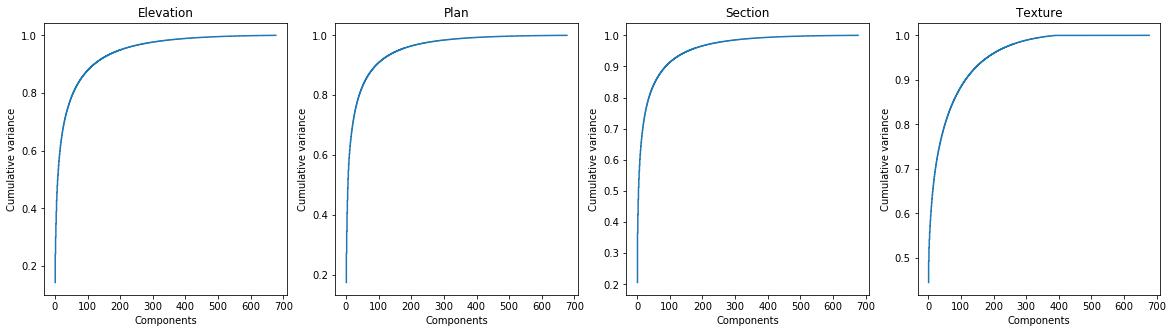

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

def pve(X):
    """
    Applies PCA to X and computes the cumulative variance.
    @param X numpy.ndarray
    @returns numpy.ndarray
    """
    pca = PCA(n_components=None) # Get the variance for all components 
    pca.fit(X, None)
    X_components = pca.transform(X)
    pve = pca.explained_variance_ratio_ # compute the cumulative variance
    pve_cum = np.cumsum(pve) # cumulative variance
    return pve_cum

def scree(ax, pve_cum, title):
    """
    Plots scree plot of cumulative variance.
    @param ax AxesSubplot
    @param pve_cum numpy.ndarray
    @param title string
    """
    xcor = np.arange(1, len(pve_cum)+1)
    ax.step(xcor, pve_cum)

    ax.set_title(title)
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative variance')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

y = metadata[:,3] # 'period' column
pve_cum_elevation = pve(elevation_features)
scree(ax[0], pve_cum_elevation, 'Elevation')
pve_cum_plan = pve(plan_features)
scree(ax[1], pve_cum_plan, 'Plan')
pve_cum_section = pve(section_features)
scree(ax[2], pve_cum_section, 'Section')
pve_cum_texture = pve(textures_features)
scree(ax[3], pve_cum_texture, 'Texture')
plt.show();

#### How many components explain what percentage of variance? 
The detailed listing below shows the percentage of variance explained by what number of components for each of the 3D views. The 'section' view requires the least number of components (157 components explain 95% of variance). 

In [8]:
import pandas as pd

def variance_table(pve_cum):
    variance_explained = []
    for l in range(10, 101, 5):
        for i in range(len(pve_cum)):
            if (pve_cum[i]*100 >= l):
                variance_explained.append({
                    'component count': i+1,
                    'percent explained': l
                })
                break
    return pd.DataFrame(variance_explained)
variance_elevation = variance_table(pve_cum_elevation)
variance_plan = variance_table(pve_cum_plan)
variance_section = variance_table(pve_cum_section)
variance_texture = variance_table(pve_cum_texture)
variance_explained = variance_elevation.rename(columns={'component count':'Component count elevation'})
variance_explained['Component count plan'] = variance_plan['component count']
variance_explained['Component count section'] = variance_section['component count']
variance_explained['Component count texture'] = variance_texture['component count']
variance_explained.set_index('percent explained', inplace=True)
variance_explained.sort_index(ascending=False)[:5]

,Component count elevation,Component count plan,Component count section,Component count texture
percent explained,,,,
100,675,675,675,NaN
95,202,162,157,181.0
90,121,93,88,115.0
85,81,60,56,77.0
80,57,41,37,52.0


#### Visualize first principal components
The section view is the view with the strongest potential. I did a principal componets analysis of the high-level features extracted from the section view, and plotted a pairplot matrix of the first 4 principal components.

The histogram of the first component looks promising, as 'Greek' and 'Roman' (in the right side of the histogram) are discernible from 'Bronze Age' and 'Neolithic LBK' on the left. However, it is clear that the classes canot be linearly separated, therefore the model used for classification will have to be capable of handling non-linear class boundaries. For the dense networks implemented in the following notebook, this means that they will have to have one or more hidden layers.

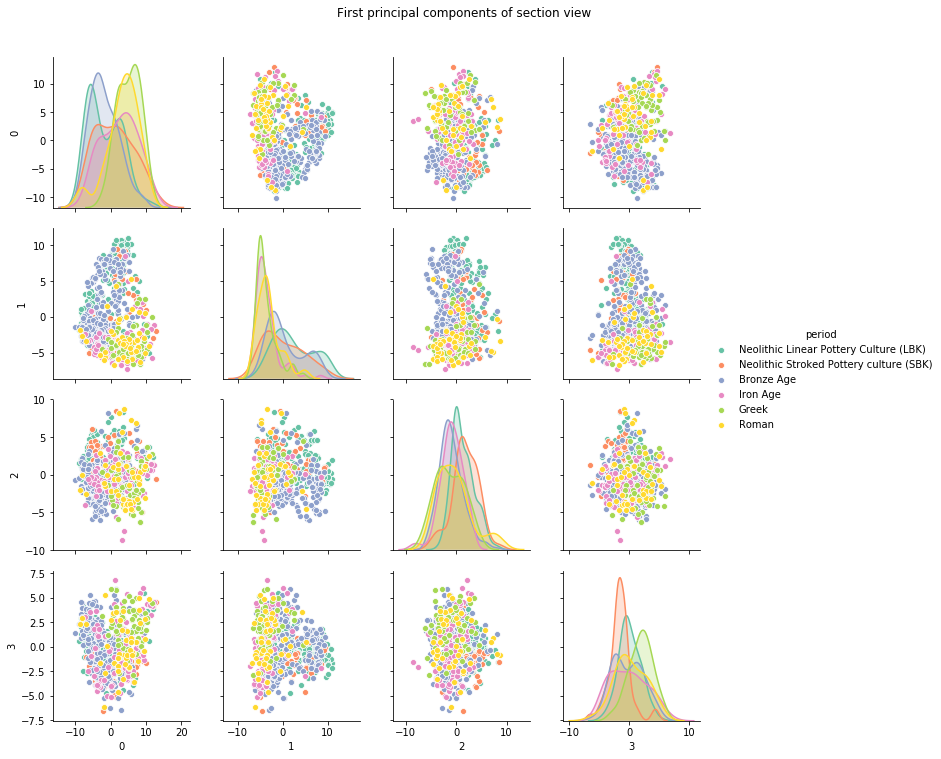

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=4) 
X = pca.fit_transform(section_features, None)

X = pd.DataFrame(X)
X['period'] = metadata[:,3] # 'period' is the 3rd metadata column

sns.pairplot(X, kind="scatter", hue='period', palette="Set2")
plt.suptitle('First principal components of section view', y=1.05)
plt.show()
 